Importing relevant packages from PyTorch

In [29]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Jan 24 16:02:40 2021

@author: s2110992
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np


Simulating Data

In [30]:
def return_sphere(r,m):
    noise_parameter = 0.05 #amount of noise away from a true sphere.
    x_eps = np.random.normal(size = m)*noise_parameter
    y_eps = np.random.normal(size = m)*noise_parameter
    z_eps = np.random.normal(size = m)*noise_parameter
    # create dataset
    Phi = 2*np.pi*np.random.rand(m) - np.pi
    Theta = np.pi*np.random.rand(m) - 0.5*np.pi
    X = r*(1+x_eps)*np.cos(Theta)*np.cos(Phi)
    Y = r*(1+y_eps)*np.cos(Theta)*np.sin(Phi)
    Z = r*(1+z_eps)*np.sin(Theta)
    data_sphere = np.array([X,Y,Z])
    return data_sphere
def return_ellipsoid(m,x_stretch,y_stretch,z_stretch):
    noise_parameter = 0.05 #amount of noise away from a true sphere.
    a_x = x_stretch#x-direction stretch
    b_y = y_stretch#y-direction stretch
    c_z  = z_stretch#z-direction stretch
    x_eps = np.random.normal(size = m)*noise_parameter
    y_eps = np.random.normal(size = m)*noise_parameter
    z_eps = np.random.normal(size = m)*noise_parameter
    # create dataset
    Phi = 2*np.pi*np.random.rand(m) - np.pi
    Theta = np.pi*np.random.rand(m) - 0.5*np.pi
    X = a_x*(1+x_eps)*np.cos(Theta)*np.cos(Phi)
    Y = b_y*(1+y_eps)*np.cos(Theta)*np.sin(Phi)
    Z = c_z*(1+z_eps)*np.sin(Theta)
    data_ellipsoid = np.array([X,Y,Z])
    return data_ellipsoid

In [31]:
training_data_size = 1000
group_size = training_data_size//2
data_size = 10000
#print(np.shape(return_sphere(100)))
training_set = np.zeros((training_data_size,3,data_size))
for i in range(group_size):
    training_set[i,:,:] = return_sphere(np.random.uniform(low = 1,high = 10),data_size)
    stretch_factor = np.random.uniform(low = 10, high = 50)
    training_set[group_size+i,:,:] = return_ellipsoid(data_size,stretch_factor,np.random.uniform(low = 1,high = 10),1/stretch_factor)
#training_set[:group_size,:] = np.random.uniform(size =(group_size,data_size))
#training_set[group_size:,:] = np.random.normal(size =(group_size,data_size))
#print(training_set[0])
training_set = np.random.permutation(training_set)
#print(training_set[0])
data_tensor = torch.FloatTensor(training_set)
#print(data_tensor[-1])
#x-stretch,y-stretch,z-stretch -> all in same data.

Training Data and Training Parameters

In [32]:
#Note we can make BATCH_SIZE smaller than training data set then it 
#does iterative gradient steps.
LEARNING_RATE = 1e-3
NUM_ITERS = 100
BATCH_SIZE = training_data_size

In [33]:
# Creating the architecture of the Neural Network

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder
        self.enc1 = nn.Linear(in_features=data_size, out_features=128)
        self.enc2 = nn.Linear(in_features = 128, out_features = 16)
        self.enc3 = nn.Linear(in_features = 16,out_features = 4)
        # decoder 
        self.dec1 = nn.Linear(in_features=4, out_features=16)
        self.dec2 = nn.Linear(in_features=16, out_features=128)
        self.dec3 = nn.Linear(in_features =128, out_features =data_size)
    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))

        
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        return x
net = Autoencoder()
print(net)
net(torch.rand(3,data_size))

Autoencoder(
  (enc1): Linear(in_features=10000, out_features=128, bias=True)
  (enc2): Linear(in_features=128, out_features=16, bias=True)
  (enc3): Linear(in_features=16, out_features=4, bias=True)
  (dec1): Linear(in_features=4, out_features=16, bias=True)
  (dec2): Linear(in_features=16, out_features=128, bias=True)
  (dec3): Linear(in_features=128, out_features=10000, bias=True)
)


tensor([[0.0801, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1256],
        [0.0790, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1263],
        [0.0805, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1270]],
       grad_fn=<ReluBackward0>)

In [34]:
#using Mean Square Error as the Loss function.
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [35]:
#Training Step!.
loss_vector = np.zeros(NUM_ITERS)
for epoch in range(NUM_ITERS):  # loop over the dataset multiple times

    running_loss = 0.0
    for i in range(training_data_size):
        # get the inputs
        inputs = data_tensor[i]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        #summing loss to work out current loss.
        running_loss += loss.item()
    loss_vector[epoch] = running_loss
    if (epoch >=10)&(abs(loss_vector[epoch] - loss_vector[epoch - 5])< 0.01)&(abs(loss_vector[epoch] - loss_vector[epoch - 10])<0.01):
        break
    #if epoch%10 ==0:
    print('running loss=',running_loss, 'epoch = ', epoch)
    
print('Finished Training')
low_dim_feat = net.enc3(F.relu(net.enc2(F.relu(net.enc1(torch.rand(data_size))))))


running loss= 50792.63616871834 epoch =  0
running loss= 50789.410125643015 epoch =  1
running loss= 50788.557924836874 epoch =  2
running loss= 50787.95982116461 epoch =  3
running loss= 50788.54399996996 epoch =  4
running loss= 50787.02022701502 epoch =  5
running loss= 50792.053306251764 epoch =  6
running loss= 50780.702934622765 epoch =  7
running loss= 50817.65041697025 epoch =  8
running loss= 50785.815679073334 epoch =  9
running loss= 50785.663892775774 epoch =  10
running loss= 50785.59223344922 epoch =  11
running loss= 50785.55257767439 epoch =  12
running loss= 50785.54979765415 epoch =  13
running loss= 50785.49442124367 epoch =  14
running loss= 50785.47392049432 epoch =  15
running loss= 50785.45943579078 epoch =  16
running loss= 50785.459429740906 epoch =  17
running loss= 50785.457803189754 epoch =  18
running loss= 50785.43792057037 epoch =  19
running loss= 50785.43562793732 epoch =  20
running loss= 50785.42943042517 epoch =  21
running loss= 50785.49495860934 ep

Cluster Feature Plot!

[[ -86.935814    -1.2786772  -43.609707     3.6756392]
 [-129.4654      -1.87869    -64.62131      4.8151865]
 [ -84.63441     -1.2462087  -42.472706     3.6139748]]


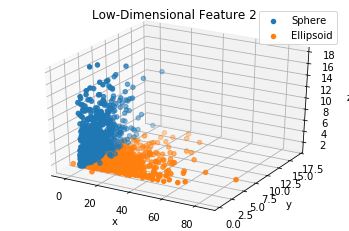

In [44]:
from mpl_toolkits.mplot3d import Axes3D
number_of_points = 1000

sphere_points = np.zeros((number_of_points,3,data_size))
ellipsoid_points = np.zeros((number_of_points,3,data_size))
for i in range(number_of_points):
    sphere_points[i,:,:] = return_sphere(np.random.uniform(low = 1,high = 10),data_size)
    stretch_factor = np.random.uniform(low = 10, high = 50)
    ellipsoid_points[i,:,:] = return_ellipsoid(data_size,stretch_factor,np.random.uniform(low = 1,high = 10),1/stretch_factor)
    

sphere_points = torch.FloatTensor(sphere_points)
#3d points each feature and see if they split up.


ellipsoid_points = torch.FloatTensor(ellipsoid_points)

sphere_feature1 = np.zeros(number_of_points)
sphere_feature2 = np.zeros(number_of_points)
sphere_feature3 = np.zeros(number_of_points)

ellipsoid_feature1 = np.zeros(number_of_points)
ellipsoid_feature2 = np.zeros(number_of_points)
ellipsoid_feature3 = np.zeros(number_of_points)

feature_number = 3
for i in range(number_of_points):
    sphere_feature = net.enc3(F.relu(net.enc2(F.relu(net.enc1(sphere_points[i])))))
    ellipsoid_feature = net.enc3(F.relu(net.enc2(F.relu(net.enc1(ellipsoid_points[i])))))
    sphere_feature= sphere_feature.detach().numpy()
    ellipsoid_feature = ellipsoid_feature.detach().numpy()
    sphere_feature1[i] = sphere_feature[0][feature_number]
    sphere_feature2[i] = sphere_feature[1][feature_number]
    sphere_feature3[i] = sphere_feature[2][feature_number]
    ellipsoid_feature1[i] = ellipsoid_feature[0][feature_number]
    ellipsoid_feature2[i] = ellipsoid_feature[1][feature_number]
    ellipsoid_feature3[i] = ellipsoid_feature[2][feature_number]
print(sphere_feature)
#m, b = np. polyfit(normal_feature1, normal_feature2, 1)  
plt.figure()
#3d plot
ax = plt.axes(projection='3d')
ax.scatter(sphere_feature1,sphere_feature2,sphere_feature3,label='Sphere')
ax.scatter(ellipsoid_feature1,ellipsoid_feature2,ellipsoid_feature3,label = 'Ellipsoid')
ax.set_title('Low-Dimensional Feature 2')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()
plt.savefig('feature2.png')
#plt.figure()
#plt.plot(sphere_feature2,sphere_feature3,'r.',label = 'Sphere')
#plt.plot(ellipsoid_feature2,ellipsoid_feature3,'b.',label = 'Ellipsoid')


Implement a batch method rather than looping through the entire training set?


Plot $L^{2}$ norm between theory and practice (after scale and shifting)

Could implement Variational Autoencoder/Diffusion Maps?

Semi-Supervised -> label normal and uniform distributions (a notion of how ordered a system is)

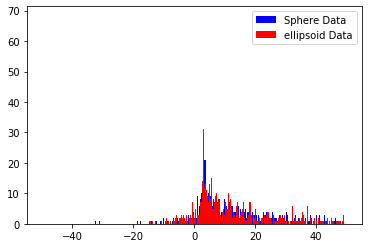

In [9]:
plt.figure()
bins = np.linspace(-50, 50, 500)
plt.hist(sphere_feature2,bins,color = 'blue', label = 'Sphere Data')
plt.hist(ellipsoid_feature2,bins,color = 'red',label = 'ellipsoid Data')

plt.legend(loc='upper right')
plt.show() #make the bar sizes the same!
